In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DP_train_df = pd.read_csv("Disease Prediction Training.csv")
DP_test_df = pd.read_csv("Disease Prediction Testing.csv")

# Section1: Data Preparation

## Potential data quality issue 

For some distance-based algorithms, normalization is required cause attributes in data set are in the same scale. Differece of unit impacts calculation of distance and makes it inaccurate.

To apply classification algorithms, all of the attributes should be the same type. A combination of numerical and categorical attributes is not allowed.

Missing value in the data set can also have a huge influence on the results.

Unvalidated data points. The data set contains index of normal human body, so there is normal range for these critirion. We need to do a research on them and figure out normal range and remove unvalidate data point out of the range.

## Data preprocessing

### Basic data cleaning

In [279]:
#test missing value
any(DP_train_df.isna().any())
any(DP_test_df.isna().any())
DP_train_df.dropna(inplace=True)
DP_test_df.dropna(inplace=True)
#remove duplicates()
DP_train_df.drop_duplicates(inplace=True)
DP_test_df.drop_duplicates(inplace=True)

### Data validation

In [5]:
#data validation remove outliers in Blood pressure
DP_train_df = DP_train_df[80 <= DP_train_df['High Blood Pressure']]
DP_train_df = DP_train_df[DP_train_df['High Blood Pressure'] <=200]
DP_train_df = DP_train_df[DP_train_df['Low Blood Pressure'] <=130]
DP_train_df = DP_train_df[DP_train_df['High Blood Pressure'] >= 40]

### Data converstion

Transform categorical attributes Glucose, Cholesterol, Gender into numeric by one-hot encoding.

In [275]:
#transfrom categorical attributes to numeric using one-hot encoder
#for naive bayes classifier
DP_train_df_NBC = pd.concat([DP_train_df, pd.get_dummies(DP_train_df['Gender']),
                            pd.get_dummies(DP_train_df['Glucose'], prefix='Glucose'),
                            pd.get_dummies(DP_train_df['Cholesterol'], prefix='Cholesterol')
                            ], axis = 1)
DP_train_df_NBC.drop(['Gender','Glucose','Cholesterol'], axis = 1, inplace = True)

### Data standardization

## Exploratory Data Analysis

### High Blood Pressure among different gender

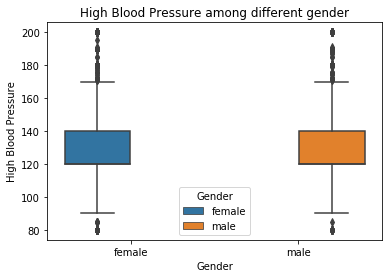

In [248]:
ax = sns.boxplot(y='High Blood Pressure', x='Gender', 
                 data=DP_train_df, hue = 'Gender')
plt.title("High Blood Pressure among different gender")
plt.show()

### Disease vs. non-disease

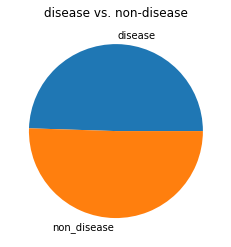

In [274]:
disease_count = DP_train_df[DP_train_df['Disease']==1].count()[0]
nondisease_count = DP_train_df[DP_train_df['Disease']==0].count()[0]
plt.figure()
plt.pie([disease_count,nondisease_count], labels=['disease','non_disease'])
plt.title("disease vs. non-disease")
plt.show()

# Section2: Model building, tuning and evaluation

## NBC 

### Data preparation

Extract target and attributes from original data set for the further usage of algorithms. Conduct a train, test set split

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
DP_train_X = DP_train_df_NBC.drop('Disease', axis=1)
DP_train_Y = DP_train_df_NBC['Disease']
X_train, X_test, Y_train, Y_test = train_test_split(DP_train_X, DP_train_Y, test_size = 0.3)

### Gaussian NB

We use accuracy as the evaluation cause it is a strong measurement of how well the classification model works

In [51]:
#fit Gaussian NB model
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
gnb_pred = gnb.predict(X_test)
print(f"Gaussian NB Accuracy: \n{round(metrics.accuracy_score(Y_test, gnb_pred)*100,2)}%")

Gaussian NB Accuracy: 
67.55%


### Mutinomial NB

#### Build the model

In [52]:
#build  
mnb = MultinomialNB(alpha = 0.5)
#
mnb.fit(X_train, Y_train)
mnb_pred = mnb.predict(X_test)
print(f"Mutinomial NB Accuracy: \n{round(metrics.accuracy_score(Y_test, mnb_pred)*100,2)}%")

Mutinomial NB Accuracy: 
70.98%


#### Hyperparameter tuning

We are going to find the best hyperparameter of zero probability smoothing for MutinomialNB by grid search. Cross validation set is also defined and will be reused for other algorithm 

In [61]:
#hyperparameter tuning
MultinomialNB_par = {'alpha':[0.1,1,10,100]}
#cross validation split
cv = ShuffleSplit(n_splits=10,test_size=0.3,random_state=5)

In [62]:
MultinomialNB_grid = GridSearchCV(MultinomialNB(), 
                                 param_grid=MutinomialNB_par,
                                cv=cv)
MultinomialNB_grid.fit(X_train, Y_train)
#best model
print("Best parameters for MutinomialNB are:")
for index, values in MultinomialNB_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for MutinomialNB are:
alpha:10


In [73]:
mnb = MultinomialNB(alpha = 10)
mnb.fit(X_train, Y_train)
mnb_pred = mnb.predict(X_test)
print(f"Multinomial NB Accuracy after tuning: \n{round(metrics.accuracy_score(Y_test, mnb_pred)*100,2)}%")

Multinomial NB Accuracy after tuning: 
70.98%


### Bernoulli NB

#### Build the model

In [67]:
bnb = BernoulliNB(alpha = 1.0)
bnb.fit(X_train, Y_train)
bnb_pred = bnb.predict(X_test)
print(f"Bernoulli NB Accuracy: \n{round(metrics.accuracy_score(Y_test, bnb_pred)*100,2)}%")

Bernoulli NB Accuracy: 
59.83%


#### Hyperparameter tuning

We are going to find the best hyperparameter of zero probability smoothing for BernoulliNB by grid search

In [70]:
#hyperparameter tuning
#alpha=[0.1,1,10]
Bernoulli_par = {'alpha':[0.1,1,10,100]}
BernoulliNB_grid = GridSearchCV(BernoulliNB(), 
                                 param_grid=MutinomialNB_par,
                                cv=cv)
BernoulliNB_grid.fit(X_train, Y_train)
#best model
print("Best parameters for MutinomialNB are:")
for index, values in BernoulliNB_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for MutinomialNB are:
alpha:10


In [74]:
bnb = BernoulliNB(alpha = 10)
bnb.fit(X_train, Y_train)
bnb_pred = bnb.predict(X_test)
print(f"Bernoulli NB Accuracy after tuning: \n{round(metrics.accuracy_score(Y_test, bnb_pred)*100,2)}%")

Bernoulli NB Accuracy after tuning: 
59.83%


## KNN

### Data preparation

KNN is a distance-based cluster algorithm so that the scale difference of features impacts on the calculation a lot. Here we need a normalization for the data

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
sc = preprocessing.StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Build the model

In [80]:
KNNC = KNeighborsClassifier()
KNNC.fit(X_train_std, Y_train)
KNN_pred = KNNC.predict(X_test_std)
print(f"KNN Accuracy: \n{round(metrics.accuracy_score(Y_test, KNN_pred)*100,2)}%")

KNN Accuracy: 
69.47%


### Hyperparameter tuning

In [82]:
#model with best parameters
knn_par = {'n_neighbors':[5,25,50,100],
          'p':[1,2]}
knn_grid =GridSearchCV(KNeighborsClassifier(),
                      param_grid=knn_par,
                      cv=cv)
knn_grid.fit(X_train_std, Y_train)
print("Best parameters for KNN are:")
for index, values in knn_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for KNN are:
n_neighbors:100
p:1


In [318]:
KNNC_best = KNeighborsClassifier(n_neighbors=100, p=1)
KNNC_best.fit(X_train_std, Y_train)
KNN_pred = KNNC.predict(X_test_std)
print(f"KNN Accuracy: \n{round(metrics.accuracy_score(Y_test, KNN_pred)*100,2)}%")
#make knn pipe
knn_pipe = make_pipeline(sc, KNNC_best)

KNN Accuracy: 
73.01%


## Linear SVM

### Data preparation

SVM is a distanced-based classifier so that normalization is required.

### Build model

In [85]:
from sklearn.svm import SVC
from sklearn import svm

In [89]:
#predict with default parameters
lin_clf = svm.LinearSVC(max_iter=10000)
lin_clf.fit(X_train_std,Y_train)
lin_clf_pred = lin_clf.predict(X_test_std)
print(f"Linear SVM Accuracy: \n {round(metrics.accuracy_score(Y_test, lin_clf_pred)*100,2)}%")

Linear SVM Accuracy: 
 73.05%


### Hyperparameter tuning

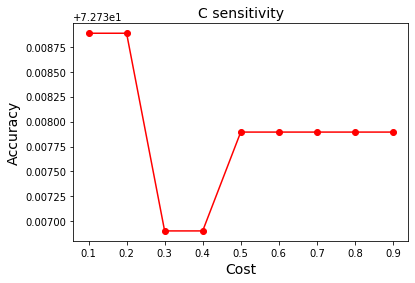

In [133]:
#manually tune C
#initialize C
C = np.arange(0.1,1,0.1)
accuracy_result_svm=[]
#for each C, construct model and calculate accuracy
for c in C:
    SVM_ = svm.LinearSVC(C=c, max_iter=10000)
    SVM_.fit(X_train_std, Y_train)
    #calculate cross validation score
    acc = cross_val_score(SVM_, X_train_std, Y_train, cv=cv).mean()*100
    accuracy_result_svm.append(acc)
plt.plot(C, accuracy_result_svm, color='red', marker='o')
plt.title('C sensitivity', fontsize=14)
plt.xlabel('Cost', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [136]:
#predict with default parameters
print("Best parameters for SVM is \n C=0.1:")
lin_clf = svm.LinearSVC(max_iter=10000,C=.1)
lin_clf.fit(X_train_std,Y_train)
lin_clf_pred = lin_clf.predict(X_test_std)
print(f"Linear SVM Accuracy after tuning: \n {round(metrics.accuracy_score(Y_test, lin_clf_pred)*100,2)}%")

Best parameters for SVM is 
 C=0.1:
Linear SVM Accuracy after tuning: 
 73.05%


### Model evaluation

In [303]:
#make svm pipe line
LinSVM_pipe = make_pipeline(sc, lin_clf)
#print evaluation report
print(metrics.classification_report(Y_test,lin_clf_pred, target_names=['predicted_neg','predicted_pos']))

               precision    recall  f1-score   support

predicted_neg       0.70      0.80      0.75      7252
predicted_pos       0.76      0.66      0.71      7175

     accuracy                           0.73     14427
    macro avg       0.73      0.73      0.73     14427
 weighted avg       0.73      0.73      0.73     14427



## Non-linear SVM

### RBF Kernel

### Build model

In [215]:
rbf_clf = svm.SVC(kernel='rbf', cache_size=2000)
rbf_clf.fit(X_train_std, Y_train)
rbf_clf_pred = rbf_clf.predict(X_test_std)
print(f"RBF SVM Accuracy: \n {round(metrics.accuracy_score(Y_test, rbf_clf_pred)*100,2)}%")

RBF SVM Accuracy after tuning: 
 73.35%


### Hyperparameter tuning

In [201]:
gamma=[0.1,0.25,0.5,0.75,1]
rbf_acc_1=[]
rbf_acc_2=[]
rbf_acc_3=[]
for g in gamma:
    #C=0.1
    rbf_model1 = SVC(C=.1, kernel='rbf', gamma=g, cache_size=2000)
    rbf_model1.fit(X_train_std, Y_train)
    #use cross validation score as evaluation
    acc=cross_val_score(rbf_model1, X_train_std, Y_train, cv=cv).mean()*100
    rbf_acc_1.append(acc)
    #C=0.5
    rbf_model2 = SVC(C=.5, kernel='rbf', gamma=g, cache_size=2000)
    rbf_model2.fit(X_train_std, Y_train)
    acc2=cross_val_score(rbf_model2, X_train_std, Y_train, cv=cv).mean()*100
    rbf_acc_2.append(acc2)
    #C=1
    rbf_model3 = SVC(C=1, kernel='rbf', gamma=g, cache_size=2000)
    rbf_model3.fit(X_train_std, Y_train)
    acc3=cross_val_score(rbf_model3, X_train_std, Y_train, cv=cv).mean()*100
    rbf_acc_3.append(acc3)
    print(f"Length of accuracy vector:{len(rbf_acc_1),len(rbf_acc_2),len(rbf_acc_3)}")

Length of accuracy vector:(1, 1, 1)
Length of accuracy vector:(2, 2, 2)
Length of accuracy vector:(3, 3, 3)
Length of accuracy vector:(4, 4, 4)
Length of accuracy vector:(5, 5, 5)


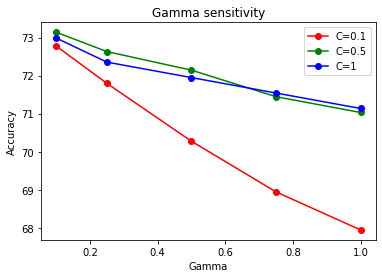

In [222]:
#sensitivity of gamma
plt.figure()
plt.plot(gamma, rbf_acc_1,'o-', color = 'r',label="C=0.1")
plt.plot(gamma, rbf_acc_2,'o-', color = 'g', label="C=0.5")
plt.plot(gamma, rbf_acc_3,'o-', color = 'b', label="C=1")
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("Gamma sensitivity")
plt.legend()
plt.show()

In [214]:
#model with the best parameters
rbf_best = SVC(C=.5, kernel='rbf', gamma=.1, cache_size=2000)
rbf_best.fit(X_train_std, Y_train)
rbf_clf_best_pred = rbf_best.predict(X_test_std)
print(f"RBF SVM Accuracy after tuning: \n {round(metrics.accuracy_score(Y_test, rbf_clf_best_pred)*100,2)}%")
#make svm pipe line
rbfSVM_pipe = make_pipeline(sc, rbf_best)

RBF SVM Accuracy after tuning: 
 73.3%


## Random forest

### Build the model

In [180]:
#random forest
from sklearn.ensemble import RandomForestClassifier
Random_forest_clf = RandomForestClassifier(n_estimators=100, max_features=5, random_state=16)
Random_forest_clf.fit(X_train, Y_train)
RF_clf_pred = Random_forest_clf.predict(X_test)
print(f"Accuracy of random forest algorithm: \n {round(metrics.accuracy_score(Y_test, RF_clf_pred)*100,2)}%")

Accuracy of random forest algorithm: 
 69.57%


### Hyperparameter tuning

In [312]:
rf_par = {'n_estimators':[10,50,100],
         'max_features':[1,2,3,5],
         'max_depth':[5,25,50],
         'criterion':['gini','entropy']}

In [313]:
random_forest_grid = GridSearchCV(RandomForestClassifier(),
                                 param_grid=rf_par,
                                 cv=cv)
random_forest_grid.fit(X_train,Y_train)
print("Best parameters for Random forest are:")
for index, values in random_forest_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for Random forest are:
criterion:entropy
max_depth:5
max_features:5
n_estimators:100


In [314]:
RF_clf_pred = random_forest_grid.predict(X_test)
print(f"Accuracy of random forest algorithm after tuning: \n {round(metrics.accuracy_score(Y_test, RF_clf_pred)*100,2)}%")

Accuracy of random forest algorithm after tuning: 
 73.06%


## Gradient boosting machine

### Build model

In [190]:
from sklearn.ensemble import GradientBoostingClassifier as GBM
GBM_clf =GBM(n_estimators=num_trees, random_state=16)
GBM_clf.fit(X_train, Y_train)
gbm_clf_pred = Random_forest_clf.predict(X_test)
print(f"Accuracy of random forest algorithm: \n {round(metrics.accuracy_score(Y_test, gbm_clf_pred)*100,2)}%")

Accuracy of random forest algorithm: 
 69.57%


### Hyperprameter tuning

In [196]:
#initialize paramaters and their range
gbm_par = {'n_estimators':[10,50,100],
         'learning_rate':[.05,.50,1],
         'max_depth':[3,5,10]}

In [197]:
GBM_grid = GridSearchCV(GBM(),
                        param_grid=gbm_par,
                        cv=cv)
GBM_grid.fit(X_train,Y_train)
print("Best parameters for Random forest are:")
for index, values in GBM_grid.best_params_.items():
    print(f"{index}:{values}")

Best parameters for Random forest are:
learning_rate:0.05
max_depth:3
n_estimators:100


In [310]:
gbm_clf_pred = GBM_grid.predict(X_test)
print(f"Accuracy of random forest algorithm after tuning: \n {round(metrics.accuracy_score(Y_test, gbm_clf_pred)*100,2)}%")

Accuracy of random forest algorithm after tuning: 
 73.43%


### Model evaluation: ROC Curve

AUC score: 
 0.8023748825266994


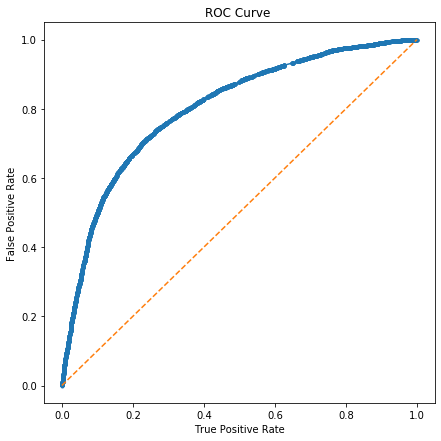

In [242]:
from sklearn.metrics import roc_curve, roc_auc_score
#predict the probability of the data points belongs to each class
gbm_pred_prob = GBM_grid.predict_proba(X_test)[:,1]
#calculate false positve, true positive rate,
#known that roc curve is TP vs. FP
FP_rate, TP_rate, threshold = roc_curve(Y_test, gbm_pred_prob)
print("AUC score: \n" ,roc_auc_score(Y_test, gbm_pred_prob))
#plot roc curve
plt.subplots(1,figsize=(7,7))
plt.title("ROC Curve ")
plt.plot(FP_rate, TP_rate, marker='.')
plt.plot([0,1], ls="--")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.show()

# Section3: Prediction and Interpretation

## Test data preparation

In [293]:
#Data preparation
DP_test_df = DP_test_df[80 <= DP_test_df['High Blood Pressure']]
DP_test_df = DP_test_df[DP_test_df['High Blood Pressure'] <=200]
DP_test_df = DP_test_df[DP_test_df['Low Blood Pressure'] <=130]
DP_test_df = DP_test_df[DP_test_df['High Blood Pressure'] >= 40]
#transfrom categorical attributes to numeric using one-hot encoder
#for naive bayes classifier
DP_test = pd.concat([DP_test_df, pd.get_dummies(DP_test_df['Gender']),
                            pd.get_dummies(DP_test_df['Glucose'], prefix='Glucose'),
                            pd.get_dummies(DP_test_df['Cholesterol'], prefix='Cholesterol')
                            ], axis = 1)
DP_test.drop(['Gender','Glucose','Cholesterol'], axis = 1, inplace = True)
#select features to predict
DP_test_X = DP_test.drop('ID', axis=1)

## Result calculation

In [296]:
#Naive Bayes
#Multinomial NB
MulNB_results = mnb.predict(DP_test_X)

In [319]:
#KNN
KNN_results = knn_pipe.predict(DP_test_X)

In [320]:
#Linear SVM
LinSVM_results = LinSVM_pipe.predict(DP_test_X)

In [306]:
#RBF SVM
rbfSNM_results = rbfSVM_pipe.predict(DP_test_X)

In [315]:
#Random Forest
randomforest_results = random_forest_grid.predict(DP_test_X)

In [311]:
#Gradient Boosting Machine
GBM_results = GBM_grid.predict(DP_test_X)

In [331]:
prediction_results = pd.DataFrame({'ID':DP_test['ID'],'NBC':MulNB_results,
                     'KNN':KNN_results,'SVM-Linear':LinSVM_results,
                    'SVM-RBF':rbfSNM_results,'RF':randomforest_results,
                     'GBM':GBM_results})

In [333]:
prediction_results.to_csv('HW_03 prediction.csv')